# 🔧 Notebook 2: Data Preprocessing & Augmentation

## Military Object Detection Dataset

This notebook covers data preprocessing, augmentation strategies, and preparation for model training.

### Objectives:
1. **Data Validation**: Verify dataset integrity and format
2. **Class Weights**: Calculate weights for handling imbalance
3. **Augmentation Design**: Define augmentation strategies
4. **Configuration**: Update YAML config for training
5. **Visualization**: Preview augmented samples

---

## 1. Setup & Imports

In [21]:
# Standard library imports
import os
import sys
from pathlib import Path
import random
import warnings
import json

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Image processing
from PIL import Image
import cv2

# YAML parsing
import yaml

# Progress bar
from tqdm.notebook import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ All imports successful!")

✅ All imports successful!


In [22]:
# Define paths
PROJECT_ROOT = Path('..')
DATASET_ROOT = PROJECT_ROOT / 'military_object_dataset'
CONFIG_PATH = PROJECT_ROOT / 'config' / 'dataset.yaml'
FIGURES_DIR = PROJECT_ROOT / 'figures'

# Dataset splits
TRAIN_IMAGES = DATASET_ROOT / 'train' / 'images'
TRAIN_LABELS = DATASET_ROOT / 'train' / 'labels'
VAL_IMAGES = DATASET_ROOT / 'val' / 'images'
VAL_LABELS = DATASET_ROOT / 'val' / 'labels'

# Load configuration
with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

CLASS_NAMES = config['names']
NUM_CLASSES = config['nc']

print(f"📋 Loaded config with {NUM_CLASSES} classes")

📋 Loaded config with 12 classes


## 2. Load EDA Results

In [23]:
# Load class distribution from EDA
class_dist_path = PROJECT_ROOT / 'config' / 'class_distribution.csv'

if class_dist_path.exists():
    class_dist_df = pd.read_csv(class_dist_path)
    print("📊 Loaded class distribution from EDA:")
    display(class_dist_df)
else:
    # Calculate from scratch if not available
    print("⚠️ Class distribution not found. Calculating...")
    from collections import Counter
    
    class_counts = Counter()
    for label_file in tqdm(list(TRAIN_LABELS.glob('*.txt')), desc="Counting"):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1
    
    class_dist_df = pd.DataFrame([
        {'Class ID': k, 'Class Name': CLASS_NAMES[k], 'Count': v}
        for k, v in sorted(class_counts.items())
    ])
    class_dist_df['Percentage'] = class_dist_df['Count'] / class_dist_df['Count'].sum() * 100
    display(class_dist_df)

📊 Loaded class distribution from EDA:


Class ID          Class Name  Count  Percentage  Weight (Inv Freq)  \
0          2       military_tank   7822   39.196232           0.002690   
1         10   military_aircraft   3510   17.588695           0.005995   
2          6             soldier   2991   14.987974           0.007035   
3          0  camouflage_soldier   2070   10.372820           0.010166   
4          4    military_vehicle    947    4.745440           0.022220   
5         11    military_warship    923    4.625175           0.022798   
6          3      military_truck    623    3.121868           0.033777   
7          1              weapon    541    2.710964           0.038896   
8          7    civilian_vehicle    270    1.352977           0.077936   
9          8  military_artillery    239    1.197635           0.088045   
10         5            civilian     18    0.090198           1.169044   
11         9              trench      2    0.010022          10.521397   

    Weight (Sqrt)  
0        0.105567  
1        0.157592  
2        0.170718  
3        0.205211  
4        0.303397  
5        0.307317  
6        0.374061  
7        0.401410  
8        0.568205  
9        0.603932  
10       2.200648  
11       6.601943

## 3. Class Weight Calculation

In [24]:
def calculate_class_weights(counts: list, method: str = 'inverse') -> np.ndarray:
    """
    Calculate class weights for handling imbalance.
    
    Methods:
        - 'inverse': Inverse frequency weighting (1/count)
        - 'sqrt': Square root of inverse frequency (gentler)
        - 'log': Logarithmic scaling
        - 'effective': Effective number of samples (good for extreme imbalance)
    """
    counts = np.array(counts, dtype=np.float32)
    total = counts.sum()
    n_classes = len(counts)
    
    if method == 'inverse':
        # Standard inverse frequency
        weights = total / (n_classes * counts)
    
    elif method == 'sqrt':
        # Square root scaling (less aggressive)
        weights = np.sqrt(total / (n_classes * counts))
    
    elif method == 'log':
        # Logarithmic scaling
        weights = np.log(total / counts + 1)
    
    elif method == 'effective':
        # Effective number of samples (CB loss style)
        beta = 0.9999
        effective_num = 1.0 - np.power(beta, counts)
        weights = (1.0 - beta) / effective_num
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Normalize so mean weight = 1
    weights = weights / weights.mean()
    
    return weights

In [25]:
# Sort by class ID and get counts
class_dist_sorted = class_dist_df.sort_values('Class ID')
counts = class_dist_sorted['Count'].values

# Calculate weights using different methods
weights_df = class_dist_sorted[['Class ID', 'Class Name', 'Count']].copy()
weights_df['Inverse'] = calculate_class_weights(counts, 'inverse')
weights_df['Sqrt'] = calculate_class_weights(counts, 'sqrt')
weights_df['Log'] = calculate_class_weights(counts, 'log')
weights_df['Effective'] = calculate_class_weights(counts, 'effective')

print("⚖️ Class Weights (Different Methods):")
print("=" * 80)
display(weights_df.round(4))

⚖️ Class Weights (Different Methods):


Class ID          Class Name  Count  Inverse    Sqrt     Log  Effective
3          0  camouflage_soldier   2070   0.0102  0.2052  0.6184     0.0112
7          1              weapon    541   0.0389  0.4014  0.9505     0.0399
0          2       military_tank   7822   0.0027  0.1056  0.3314     0.0039
6          3      military_truck    623   0.0338  0.3741  0.9146     0.0348
4          4    military_vehicle    947   0.0222  0.3034  0.8092     0.0233
10         5            civilian     18   1.1690  2.2006  1.8336     1.1689
2          6             soldier   2991   0.0070  0.1707  0.5328     0.0081
8          7    civilian_vehicle    270   0.0779  0.5682  1.1287     0.0789
9          8  military_artillery    239   0.0880  0.6039  1.1602     0.0890
11         9              trench      2  10.5214  6.6019  2.4080    10.5110
1         10   military_aircraft   3510   0.0060  0.1576  0.4968     0.0071
5         11    military_warship    923   0.0228  0.3073  0.8156     0.0238

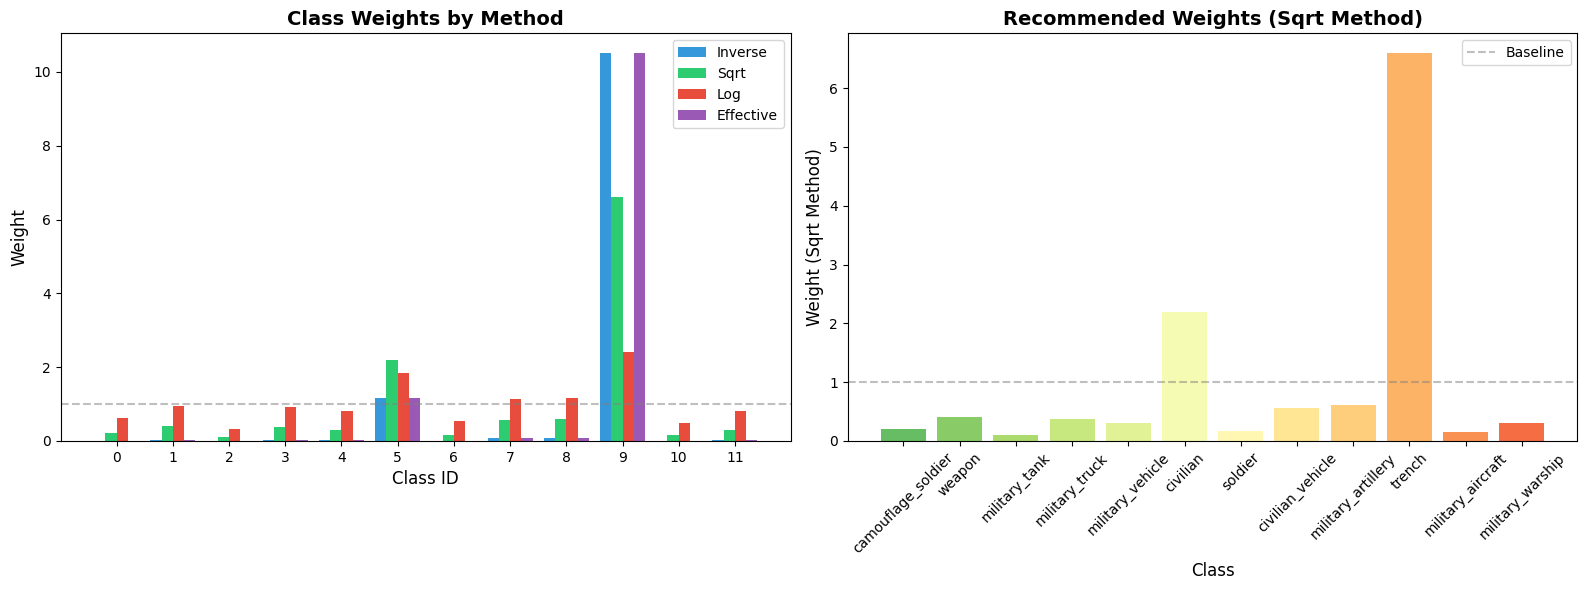

💾 Figure saved to: figures/09_class_weights.png


In [26]:
# Visualize class weights
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
x = np.arange(NUM_CLASSES)
width = 0.2

axes[0].bar(x - 1.5*width, weights_df['Inverse'], width, label='Inverse', color='#3498db')
axes[0].bar(x - 0.5*width, weights_df['Sqrt'], width, label='Sqrt', color='#2ecc71')
axes[0].bar(x + 0.5*width, weights_df['Log'], width, label='Log', color='#e74c3c')
axes[0].bar(x + 1.5*width, weights_df['Effective'], width, label='Effective', color='#9b59b6')

axes[0].set_xlabel('Class ID', fontsize=12)
axes[0].set_ylabel('Weight', fontsize=12)
axes[0].set_title('Class Weights by Method', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].legend()
axes[0].axhline(1.0, color='gray', linestyle='--', alpha=0.5)

# Focus on recommended method (Sqrt - balanced approach)
colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, NUM_CLASSES))
bars = axes[1].bar(weights_df['Class Name'], weights_df['Sqrt'], color=colors)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Weight (Sqrt Method)', fontsize=12)
axes[1].set_title('Recommended Weights (Sqrt Method)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Baseline')
axes[1].legend()

plt.tight_layout()
plt.savefig('../figures/09_class_weights.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/09_class_weights.png")

In [27]:
# Save recommended weights for training
# Using Sqrt method as a balanced approach
recommended_weights = weights_df['Sqrt'].values

# Cap extreme weights to prevent instability
MAX_WEIGHT = 10.0
capped_weights = np.clip(recommended_weights, 0.1, MAX_WEIGHT)
capped_weights = capped_weights / capped_weights.mean()  # Re-normalize

weights_dict = {int(row['Class ID']): float(capped_weights[i]) for i, row in weights_df.iterrows()}

print("📦 Final Class Weights (capped and normalized):")
for class_id, weight in weights_dict.items():
    print(f"   Class {class_id:2d} ({CLASS_NAMES[class_id]:20s}): {weight:.4f}")

# Save to config
weights_path = PROJECT_ROOT / 'config' / 'class_weights.json'
with open(weights_path, 'w') as f:
    json.dump(weights_dict, f, indent=2)

print(f"\n💾 Weights saved to: {weights_path}")

📦 Final Class Weights (capped and normalized):
   Class  0 (camouflage_soldier  ): 0.3741
   Class  1 (weapon              ): 0.5682
   Class  2 (military_tank       ): 0.2052
   Class  3 (military_truck      ): 0.1707
   Class  4 (military_vehicle    ): 0.3034
   Class  5 (civilian            ): 0.1576
   Class  6 (soldier             ): 0.1056
   Class  7 (civilian_vehicle    ): 0.6039
   Class  8 (military_artillery  ): 6.6019
   Class  9 (trench              ): 0.3073
   Class 10 (military_aircraft   ): 0.4014
   Class 11 (military_warship    ): 2.2006

💾 Weights saved to: ../config/class_weights.json


## 4. Augmentation Strategies

In [28]:
# Define augmentation parameters for YOLOv8
# These will be passed to the model.train() function

AUGMENTATION_CONFIG = {
    # === Basic Augmentations ===
    'hsv_h': 0.015,       # HSV-Hue augmentation (fraction)
    'hsv_s': 0.7,         # HSV-Saturation augmentation (fraction)
    'hsv_v': 0.4,         # HSV-Value augmentation (fraction)
    
    # === Geometric Transforms ===
    'degrees': 10.0,      # Rotation (+/- degrees)
    'translate': 0.1,     # Translation (+/- fraction)
    'scale': 0.5,         # Scale (+/- gain)
    'shear': 0.0,         # Shear (+/- degrees) - keeping 0 for military objects
    'perspective': 0.0,   # Perspective (+/- fraction) - not for detection
    
    # === Flip ===
    'flipud': 0.0,        # Flip up-down (probability) - not suitable for ground vehicles
    'fliplr': 0.5,        # Flip left-right (probability)
    
    # === Advanced Augmentations ===
    'mosaic': 1.0,        # Mosaic augmentation (probability) - combines 4 images
    'mixup': 0.1,         # Mixup augmentation (probability) - blends 2 images
    'copy_paste': 0.1,    # Copy-paste augmentation (probability) - for minority classes
    
    # === Image Processing ===
    'erasing': 0.4,       # Random erasing (probability)
    'crop_fraction': 1.0, # Image crop fraction for classification (not used for detection)
}

print("🔧 YOLOv8 Augmentation Configuration:")
print("=" * 50)
for key, value in AUGMENTATION_CONFIG.items():
    print(f"   {key:20s}: {value}")

🔧 YOLOv8 Augmentation Configuration:
   hsv_h               : 0.015
   hsv_s               : 0.7
   hsv_v               : 0.4
   degrees             : 10.0
   translate           : 0.1
   scale               : 0.5
   shear               : 0.0
   perspective         : 0.0
   flipud              : 0.0
   fliplr              : 0.5
   mosaic              : 1.0
   mixup               : 0.1
   copy_paste          : 0.1
   erasing             : 0.4
   crop_fraction       : 1.0


In [29]:
# Save augmentation config
aug_config_path = PROJECT_ROOT / 'config' / 'augmentation_config.json'
with open(aug_config_path, 'w') as f:
    json.dump(AUGMENTATION_CONFIG, f, indent=2)

print(f"💾 Augmentation config saved to: {aug_config_path}")

💾 Augmentation config saved to: ../config/augmentation_config.json


## 5. Preview Augmentations

In [30]:
def apply_hsv_augmentation(image: np.ndarray, h_gain: float, s_gain: float, v_gain: float) -> np.ndarray:
    """Apply HSV augmentation to an image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    
    # Random gains
    h_shift = np.random.uniform(-h_gain, h_gain) * 180
    s_scale = np.random.uniform(1 - s_gain, 1 + s_gain)
    v_scale = np.random.uniform(1 - v_gain, 1 + v_gain)
    
    hsv[:, :, 0] = (hsv[:, :, 0] + h_shift) % 180
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * s_scale, 0, 255)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * v_scale, 0, 255)
    
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)


def apply_random_flip(image: np.ndarray, horizontal: bool = True) -> tuple:
    """Apply random horizontal flip."""
    if horizontal and random.random() < 0.5:
        return cv2.flip(image, 1), True
    return image, False


def apply_random_rotation(image: np.ndarray, max_angle: float = 10) -> np.ndarray:
    """Apply random rotation."""
    angle = np.random.uniform(-max_angle, max_angle)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

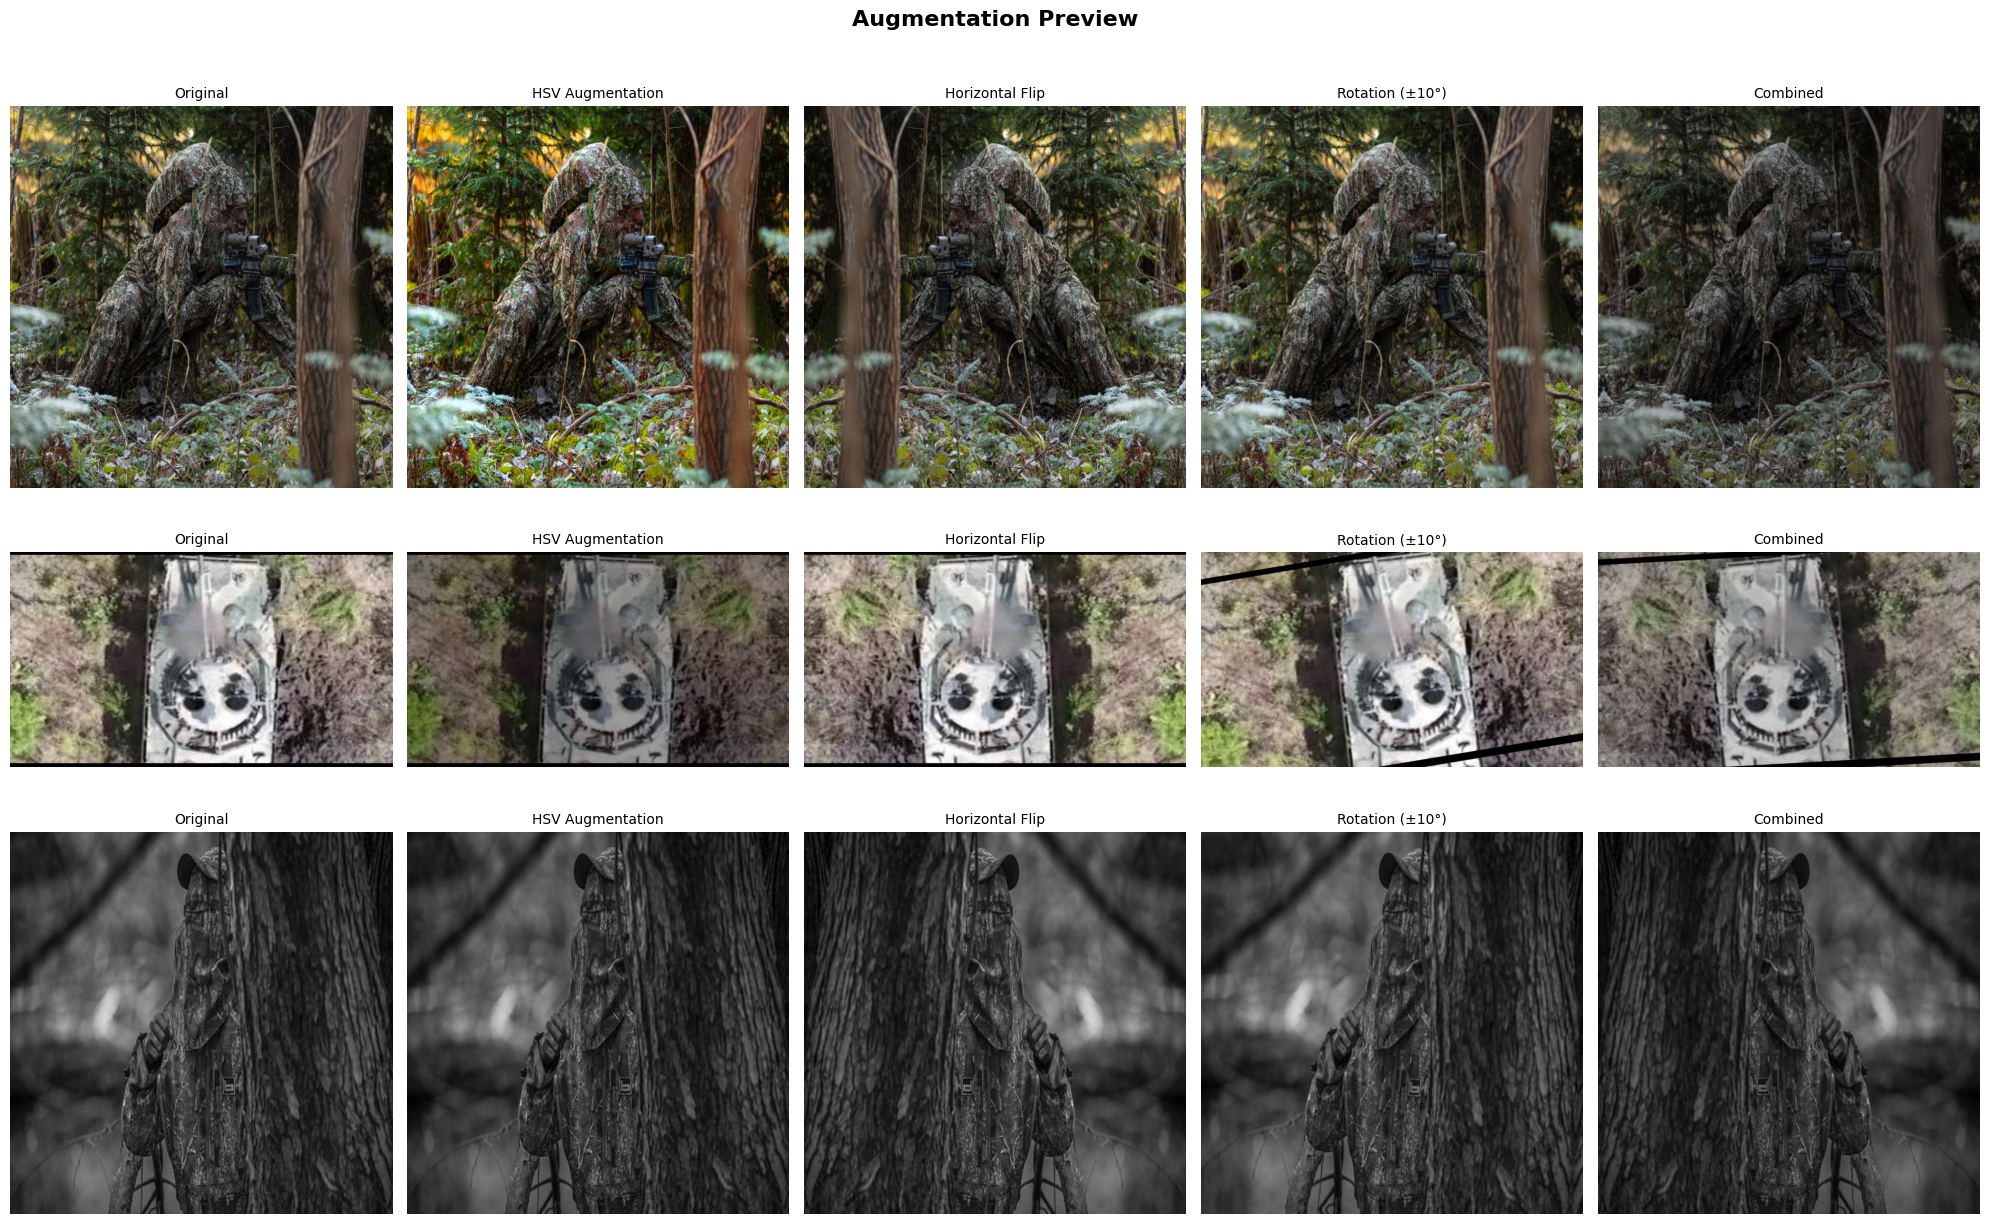

💾 Figure saved to: figures/10_augmentation_preview.png


In [31]:
# Preview augmentations on sample image
sample_images = list(TRAIN_IMAGES.glob('*.jpg'))[:3]

fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for row, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original
    axes[row, 0].imshow(img)
    axes[row, 0].set_title('Original', fontsize=10)
    axes[row, 0].axis('off')
    
    # HSV augmentation
    aug_hsv = apply_hsv_augmentation(img, 0.015, 0.7, 0.4)
    axes[row, 1].imshow(aug_hsv)
    axes[row, 1].set_title('HSV Augmentation', fontsize=10)
    axes[row, 1].axis('off')
    
    # Horizontal flip
    aug_flip = cv2.flip(img, 1)
    axes[row, 2].imshow(aug_flip)
    axes[row, 2].set_title('Horizontal Flip', fontsize=10)
    axes[row, 2].axis('off')
    
    # Rotation
    aug_rot = apply_random_rotation(img, 10)
    axes[row, 3].imshow(aug_rot)
    axes[row, 3].set_title('Rotation (±10°)', fontsize=10)
    axes[row, 3].axis('off')
    
    # Combined augmentation
    aug_combined = apply_hsv_augmentation(img, 0.015, 0.5, 0.3)
    aug_combined = apply_random_rotation(aug_combined, 5)
    if random.random() < 0.5:
        aug_combined = cv2.flip(aug_combined, 1)
    axes[row, 4].imshow(aug_combined)
    axes[row, 4].set_title('Combined', fontsize=10)
    axes[row, 4].axis('off')

plt.suptitle('Augmentation Preview', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/10_augmentation_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/10_augmentation_preview.png")

## 6. Mosaic Augmentation Visualization

In [32]:
def create_mosaic(image_paths: list, target_size: int = 640) -> np.ndarray:
    """
    Create a mosaic of 4 images (similar to YOLOv4/v5/v8 mosaic augmentation).
    This is a simplified visualization - actual YOLO mosaic includes bbox handling.
    """
    # Random center point
    center_x = random.randint(target_size // 4, 3 * target_size // 4)
    center_y = random.randint(target_size // 4, 3 * target_size // 4)
    
    # Create mosaic canvas
    mosaic = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    for i, img_path in enumerate(image_paths[:4]):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (target_size // 2, target_size // 2))
        
        if i == 0:  # Top-left
            mosaic[:center_y, :center_x] = cv2.resize(img, (center_x, center_y))
        elif i == 1:  # Top-right
            mosaic[:center_y, center_x:] = cv2.resize(img, (target_size - center_x, center_y))
        elif i == 2:  # Bottom-left
            mosaic[center_y:, :center_x] = cv2.resize(img, (center_x, target_size - center_y))
        else:  # Bottom-right
            mosaic[center_y:, center_x:] = cv2.resize(img, (target_size - center_x, target_size - center_y))
    
    return mosaic

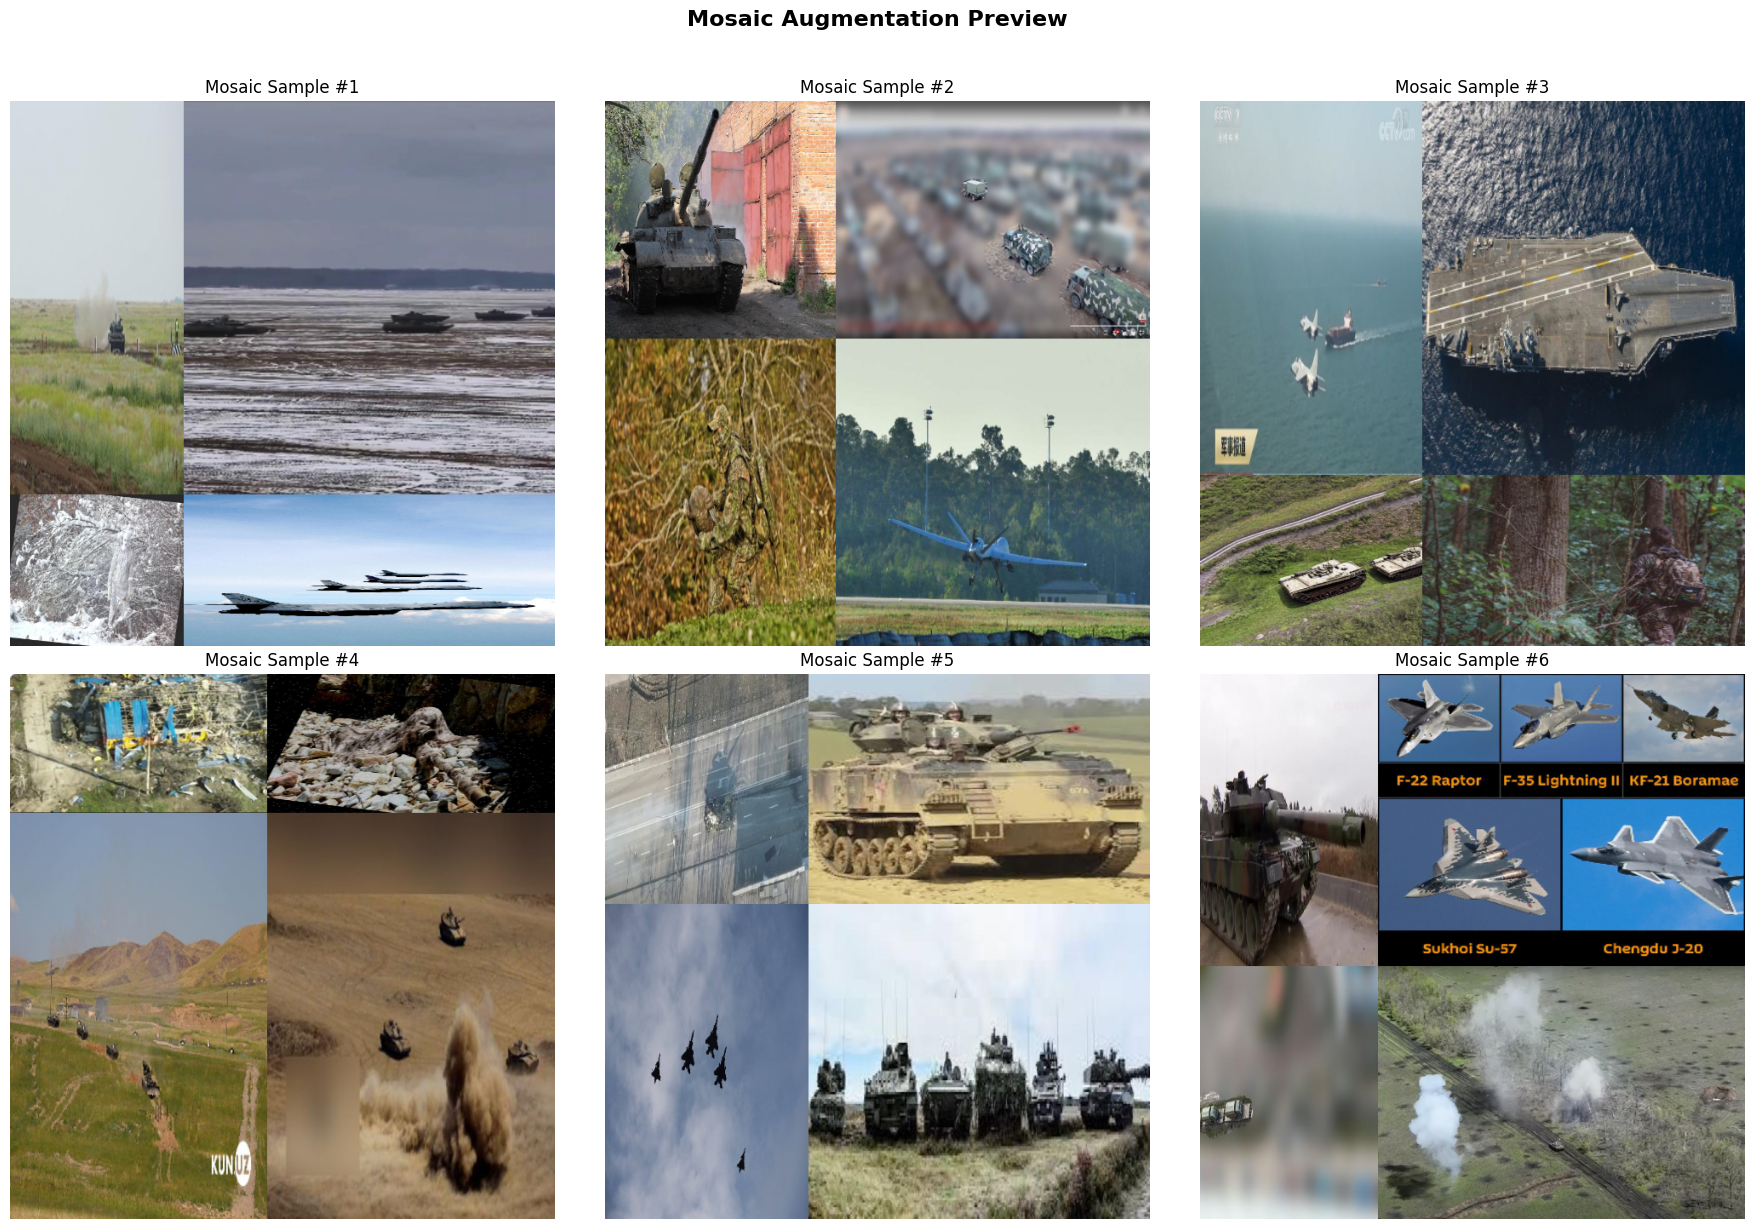

💾 Figure saved to: figures/11_mosaic_preview.png


In [33]:
# Visualize mosaic augmentation
train_images = list(TRAIN_IMAGES.glob('*.jpg'))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(6):
    row, col = i // 3, i % 3
    
    # Select 4 random images
    selected = random.sample(train_images, 4)
    mosaic = create_mosaic(selected)
    
    axes[row, col].imshow(mosaic)
    axes[row, col].set_title(f'Mosaic Sample #{i+1}', fontsize=12)
    axes[row, col].axis('off')

plt.suptitle('Mosaic Augmentation Preview', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/11_mosaic_preview.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Figure saved to: figures/11_mosaic_preview.png")

## 7. Training Configuration

In [34]:
# Define training configurations for different experiments

TRAINING_CONFIGS = {
    'baseline': {
        'model': 'yolov8n.pt',
        'epochs': 50,
        'batch': 16,
        'imgsz': 640,
        'patience': 15,
        'optimizer': 'auto',
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 0.0,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.0,
        'copy_paste': 0.0,
    },
    'improved': {
        'model': 'yolov8s.pt',
        'epochs': 75,
        'batch': 16,
        'imgsz': 640,
        'patience': 20,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 3.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 10.0,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.1,
        'copy_paste': 0.1,
    },
    'best': {
        'model': 'yolov8m.pt',
        'epochs': 100,
        'batch': 8,  # Smaller batch for larger model
        'imgsz': 640,
        'patience': 25,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005,
        'warmup_epochs': 5.0,
        'warmup_momentum': 0.8,
        'warmup_bias_lr': 0.1,
        'box': 7.5,
        'cls': 0.5,
        'dfl': 1.5,
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 10.0,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.15,
        'copy_paste': 0.1,
    }
}

print("📋 Training Configurations:")
print("=" * 60)
for name, config in TRAINING_CONFIGS.items():
    print(f"\n🔹 {name.upper()}:")
    print(f"   Model: {config['model']}")
    print(f"   Epochs: {config['epochs']}")
    print(f"   Batch Size: {config['batch']}")
    print(f"   Optimizer: {config['optimizer']}")
    print(f"   Learning Rate: {config['lr0']}")

📋 Training Configurations:

🔹 BASELINE:
   Model: yolov8n.pt
   Epochs: 50
   Batch Size: 16
   Optimizer: auto
   Learning Rate: 0.01

🔹 IMPROVED:
   Model: yolov8s.pt
   Epochs: 75
   Batch Size: 16
   Optimizer: AdamW
   Learning Rate: 0.001

🔹 BEST:
   Model: yolov8m.pt
   Epochs: 100
   Batch Size: 8
   Optimizer: AdamW
   Learning Rate: 0.001


In [35]:
# Save training configurations
training_config_path = PROJECT_ROOT / 'config' / 'training_configs.json'
with open(training_config_path, 'w') as f:
    json.dump(TRAINING_CONFIGS, f, indent=2)

print(f"💾 Training configs saved to: {training_config_path}")

💾 Training configs saved to: ../config/training_configs.json


## 8. Data Validation

In [36]:
def validate_annotation(line: str, num_classes: int) -> tuple:
    """Validate a single annotation line."""
    parts = line.strip().split()
    
    if len(parts) < 5:
        return False, "Insufficient fields"
    
    try:
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
    except ValueError:
        return False, "Non-numeric values"
    
    if class_id < 0 or class_id >= num_classes:
        return False, f"Invalid class ID: {class_id}"
    
    if not (0 <= x_center <= 1 and 0 <= y_center <= 1):
        return False, "Center out of bounds"
    
    if not (0 < width <= 1 and 0 < height <= 1):
        return False, "Invalid dimensions"
    
    return True, "OK"


def validate_dataset(labels_dir: Path, num_classes: int) -> dict:
    """Validate all annotations in a directory."""
    results = {
        'total_files': 0,
        'valid_files': 0,
        'empty_files': 0,
        'total_annotations': 0,
        'valid_annotations': 0,
        'errors': []
    }
    
    label_files = list(labels_dir.glob('*.txt'))
    results['total_files'] = len(label_files)
    
    for label_file in tqdm(label_files, desc="Validating"):
        with open(label_file, 'r') as f:
            lines = f.readlines()
        
        if len(lines) == 0 or all(not line.strip() for line in lines):
            results['empty_files'] += 1
            results['valid_files'] += 1  # Empty is valid
            continue
        
        file_valid = True
        for line in lines:
            if not line.strip():
                continue
            
            results['total_annotations'] += 1
            valid, message = validate_annotation(line, num_classes)
            
            if valid:
                results['valid_annotations'] += 1
            else:
                file_valid = False
                results['errors'].append({
                    'file': label_file.name,
                    'line': line.strip(),
                    'error': message
                })
        
        if file_valid:
            results['valid_files'] += 1
    
    return results

In [37]:
# Validate training data
print("🔍 Validating training dataset...")
train_validation = validate_dataset(TRAIN_LABELS, NUM_CLASSES)

print(f"\n📊 Training Data Validation Report:")
print("=" * 50)
print(f"   Total label files: {train_validation['total_files']:,}")
print(f"   Valid files: {train_validation['valid_files']:,}")
print(f"   Empty files: {train_validation['empty_files']:,}")
print(f"   Total annotations: {train_validation['total_annotations']:,}")
print(f"   Valid annotations: {train_validation['valid_annotations']:,}")
print(f"   Errors: {len(train_validation['errors'])}")

# Show sample errors if any
if train_validation['errors']:
    print(f"\n⚠️ Sample Errors (first 5):")
    for error in train_validation['errors'][:5]:
        print(f"   File: {error['file']}")
        print(f"   Line: {error['line']}")
        print(f"   Error: {error['error']}")
        print()

🔍 Validating training dataset...


Validating:   0%|          | 0/10000 [00:00<?, ?it/s]


📊 Training Data Validation Report:
   Total label files: 10,000
   Valid files: 9,991
   Empty files: 123
   Total annotations: 19,956
   Valid annotations: 19,947
   Errors: 9

⚠️ Sample Errors (first 5):
   File: 009464.txt
   Line: 8 0.38125 0.2962962962962963 0.0020833333333333333 0
   Error: Invalid dimensions

   File: 007947.txt
   Line: 2 0.8265625 0.16203703703703703 0 0.001851851851851852
   Error: Invalid dimensions

   File: 009212.txt
   Line: 6 0.484765625 0.4652777777777778 0 0
   Error: Invalid dimensions

   File: 009195.txt
   Line: 2 0.6317330210772834 0.52734375 0 0.0015625
   Error: Invalid dimensions

   File: 009590.txt
   Line: 8 0.8767688679245284 0.33472803347280333 0.0023584905660377358 0
   Error: Invalid dimensions



In [38]:
# Validate validation data
print("🔍 Validating validation dataset...")
val_validation = validate_dataset(VAL_LABELS, NUM_CLASSES)

print(f"\n📊 Validation Data Report:")
print("=" * 50)
print(f"   Total label files: {val_validation['total_files']:,}")
print(f"   Valid files: {val_validation['valid_files']:,}")
print(f"   Valid annotations: {val_validation['valid_annotations']:,}")
print(f"   Errors: {len(val_validation['errors'])}")

🔍 Validating validation dataset...


Validating:   0%|          | 0/2941 [00:00<?, ?it/s]


📊 Validation Data Report:
   Total label files: 2,941
   Valid files: 2,941
   Valid annotations: 5,081
   Errors: 0


## 9. Summary

In [39]:
print("=" * 70)
print("📦 PREPROCESSING & AUGMENTATION SUMMARY")
print("=" * 70)

print("\n📁 OUTPUT FILES CREATED:")
print(f"   • config/class_weights.json")
print(f"   • config/augmentation_config.json")
print(f"   • config/training_configs.json")

print("\n⚖️ CLASS WEIGHTING STRATEGY:")
print(f"   • Method: Square root of inverse frequency (balanced approach)")
print(f"   • Max weight cap: {MAX_WEIGHT}")
print(f"   • Minority class boost: ~{capped_weights.max():.1f}x")

print("\n🔧 AUGMENTATION STRATEGY:")
print("   • HSV color jitter (H=±1.5%, S=±70%, V=±40%)")
print("   • Random horizontal flip (50%)")
print("   • Rotation (±10°)")
print("   • Scale (±50%)")
print("   • Mosaic augmentation (100%)")
print("   • Mixup augmentation (10-15%)")
print("   • Copy-paste for minority classes (10%)")

print("\n🎯 TRAINING EXPERIMENTS PLANNED:")
print("   1. Baseline: YOLOv8n, 50 epochs, minimal augmentation")
print("   2. Improved: YOLOv8s, 75 epochs, full augmentation")
print("   3. Best: YOLOv8m, 100 epochs, optimized settings")

print("\n✅ DATA VALIDATION:")
train_valid = train_validation['valid_annotations'] == train_validation['total_annotations']
val_valid = val_validation['valid_annotations'] == val_validation['total_annotations']
print(f"   • Training set: {'✅ All valid' if train_valid else '⚠️ Has errors'}")
print(f"   • Validation set: {'✅ All valid' if val_valid else '⚠️ Has errors'}")

print("\n" + "=" * 70)

📦 PREPROCESSING & AUGMENTATION SUMMARY

📁 OUTPUT FILES CREATED:
   • config/class_weights.json
   • config/augmentation_config.json
   • config/training_configs.json

⚖️ CLASS WEIGHTING STRATEGY:
   • Method: Square root of inverse frequency (balanced approach)
   • Max weight cap: 10.0
   • Minority class boost: ~6.6x

🔧 AUGMENTATION STRATEGY:
   • HSV color jitter (H=±1.5%, S=±70%, V=±40%)
   • Random horizontal flip (50%)
   • Rotation (±10°)
   • Scale (±50%)
   • Mosaic augmentation (100%)
   • Mixup augmentation (10-15%)
   • Copy-paste for minority classes (10%)

🎯 TRAINING EXPERIMENTS PLANNED:
   1. Baseline: YOLOv8n, 50 epochs, minimal augmentation
   2. Improved: YOLOv8s, 75 epochs, full augmentation
   3. Best: YOLOv8m, 100 epochs, optimized settings

✅ DATA VALIDATION:
   • Training set: ⚠️ Has errors
   • Validation set: ✅ All valid



In [40]:
print("\n✅ Preprocessing Complete! Proceed to Notebook 03: Training")


✅ Preprocessing Complete! Proceed to Notebook 03: Training
